In [12]:
import pandas as pd

# Wczytaj plik i arkusz
plik = "RYNE_2961_XTAB_20250604115813.xlsx"
df = pd.read_excel(plik, sheet_name="TABLICA", header=[0, 1], skiprows=[2])

# Zostaw tylko drugi wiersz (z danymi)
df_data = df.iloc[1:].copy()

# Zamień nagłówki MultiIndex na jeden poziom (miesiąc_indeks)
df_data.columns = [f"{month}_{i}" for month, i in df_data.columns]

# Rozwiń dane do formatu długiego
df_long = df_data.melt(var_name="MiesiacRok", value_name="Wartosc")

# Podziel kolumnę na miesiąc i indeks roku
df_long[["Miesiac", "Rok_idx"]] = df_long["MiesiacRok"].str.extract(r"([a-zęóąśłżźćń]+)_(\d+)")
df_long = df_long.dropna(subset=["Rok_idx"])

# Zamień miesiące na liczby
miesiace_dict = {
    "styczeń": 1, "luty": 2, "marzec": 3, "kwiecień": 4,
    "maj": 5, "czerwiec": 6, "lipiec": 7, "sierpień": 8,
    "wrzesień": 9, "październik": 10, "listopad": 11, "grudzień": 12
}
df_long["Miesiac_num"] = df_long["Miesiac"].map(miesiace_dict)

# Indeksy lat (ogółem, ogółem.1, ..., ogółem.14)
lata = list(range(2011, 2026))
df_long["Rok_idx"] = df_long["Rok_idx"].astype(int)
df_long = df_long[df_long["Rok_idx"] < len(lata)]
df_long["Rok"] = df_long["Rok_idx"].map(lambda i: lata[i])

# Tworzenie daty
df_long["Data"] = pd.to_datetime(dict(
    year=df_long["Rok"],
    month=df_long["Miesiac_num"],
    day=1
))

# Konwersja wartości
df_long["Wartosc"] = pd.to_numeric(df_long["Wartosc"], errors="coerce")

# Końcowy format
df_final = df_long[["Data", "Wartosc"]].dropna().sort_values("Data").reset_index(drop=True)

# Zapisz do pliku Excel
output_file = "bezrobocie_czasowe.xlsx"
df_final.to_excel(output_file, index=False)

output_file


'bezrobocie_czasowe.xlsx'

In [14]:
import pandas as pd

plik = "TURY_2882_XTAB_20250604123819.xlsx"
df = pd.read_excel(plik, sheet_name="TABLICA", header=[0, 1], skiprows=[2])

# Zostaw tylko dane z drugiego wiersza (czyli z indeksem 1)
df_data = df.iloc[1:].copy()

# Usuń kolumny 'Kod' i 'Nazwa'
df_data = df_data.drop(columns=[('Kod', 'Unnamed: 0_level_1'), ('Nazwa', 'Unnamed: 1_level_1')])

# Przekształć MultiIndex kolumn na jeden poziom stringowy
df_data.columns = [f"{a}_{b}" for a, b in df_data.columns]

# Rozwiń dane do długiego formatu
df_long = df_data.melt(var_name="MiesiacKolumna", value_name="Wartosc")

# Podziel nazwę kolumny na miesiąc i indeks roku
df_long[["Miesiac", "Rok_idx"]] = df_long["MiesiacKolumna"].str.extract(r"([a-zęóąśłżźćń]+)_(?:ogółem\.?)(\d*)")

# Uzupełnij brakujące indeksy jako 0
df_long["Rok_idx"] = df_long["Rok_idx"].replace('', '0').astype(int)

# Mapa indeksów lat
lata = list(range(2011, 2026))
df_long["Rok"] = df_long["Rok_idx"].map(lambda i: lata[i] if i < len(lata) else None)

# Miesiące na liczby
miesiace_dict = {
    "styczeń": 1, "luty": 2, "marzec": 3, "kwiecień": 4,
    "maj": 5, "czerwiec": 6, "lipiec": 7, "sierpień": 8,
    "wrzesień": 9, "październik": 10, "listopad": 11, "grudzień": 12
}
df_long["Miesiac_num"] = df_long["Miesiac"].map(miesiace_dict)

# Data
df_long["Data"] = pd.to_datetime(dict(
    year=df_long["Rok"],
    month=df_long["Miesiac_num"],
    day=1
), errors="coerce")

# Wartości liczbowe
df_long["Wartosc"] = pd.to_numeric(df_long["Wartosc"], errors="coerce")

# Finał
df_final = df_long[["Data", "Wartosc"]].dropna().sort_values("Data").reset_index(drop=True)

# Zapisz wynik
output_file = "turystyka_czasowe.xlsx"
df_final.to_excel(output_file, index=False)

print("✅ Zapisano:", output_file)


ValueError: cannot convert float NaN to integer

In [ ]:
# === Importy ===
import pandas as pd
import warnings
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from IPython.display import display, HTML

warnings.filterwarnings("ignore")


file_path = "turystyka_czasowe_2.xlsx"
df = pd.read_excel(file_path)

y = df["Wartosc"].dropna().reset_index(drop=True)

# === Pętla po ARIMA(p,d,q) ===
results = []

for p, d, q in product(range(1, 4), repeat=3):
    try:
        model = ARIMA(endog=y, order=(p, d, q))
        fitted = model.fit()
        res = fitted.resid.dropna()

        adf_pvalue = adfuller(res)[1]
        ljungbox_pvalue = acorr_ljungbox(res, lags=[10], return_df=True)['lb_pvalue'].iloc[0]

        results.append({
            "p": p,
            "d": d,
            "q": q,
            "AIC": round(fitted.aic, 2),
            "BIC": round(fitted.bic, 2),
            "ADF_pvalue": round(adf_pvalue, 5),
            "LjungBox_pvalue": round(ljungbox_pvalue, 5)
        })

    except Exception as e:
        results.append({
            "p": p,
            "d": d,
            "q": q,
            "AIC": None,
            "BIC": None,
            "ADF_pvalue": None,
            "LjungBox_pvalue": None,
            "Error": str(e)
        })

# === Tworzenie DataFrame ===
results_df = pd.DataFrame(results)

# === Wyświetlenie w formie przewijalnej tabeli ===
html_table = results_df.to_html(index=False)
display(HTML(f'<div style="height:400px; overflow:auto; border:1px solid #ccc">{html_table}</div>'))


p,d,q,AIC,BIC,ADF_pvalue,LjungBox_pvalue
1,1,1,4863.21,4872.62,0.00008,0.00006
1,1,2,4859.59,4872.14,0.00002,0.00178
1,1,3,4853.87,4869.55,0.00802,0.10530
1,1,4,4829.45,4848.26,0.23835,0.84106
1,2,1,4844.66,4854.05,0.00018,0.00012
1,2,2,4844.71,4857.23,0.00108,0.00024
1,2,3,4840.96,4856.61,0.00783,0.00433
1,2,4,4829.73,4848.51,0.00705,0.14920
1,3,1,4867.44,4876.81,0.00000,0.00034
1,3,2,4863.40,4875.90,0.00000,0.00013


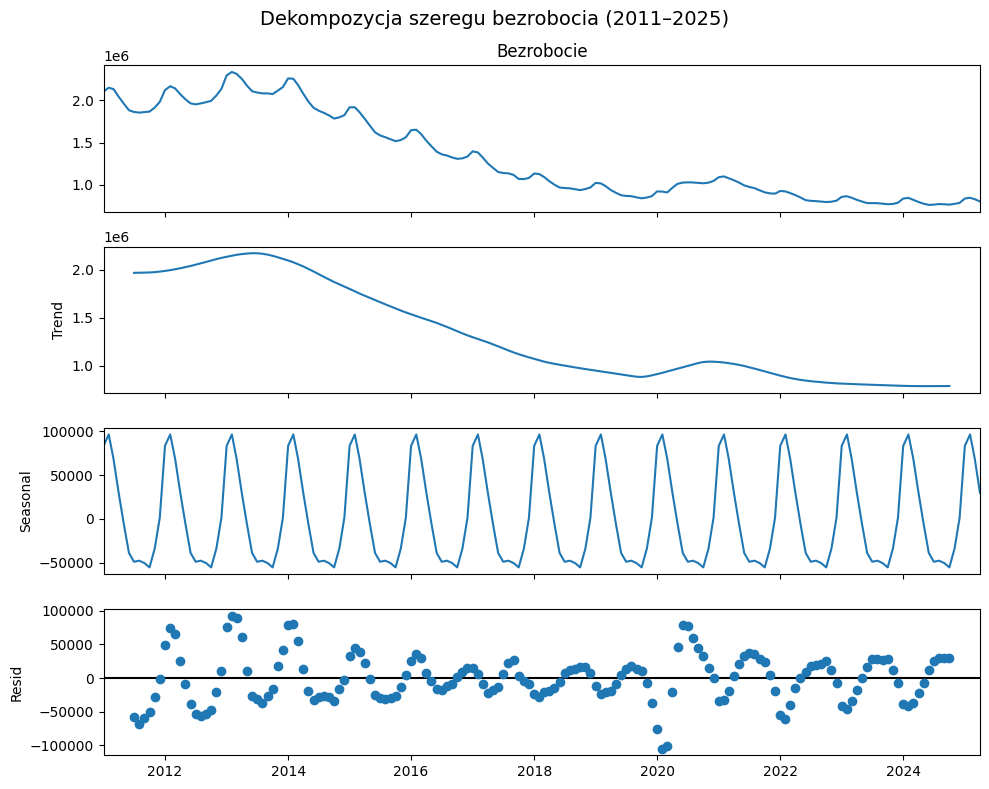

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# === Wczytanie danych ===
file_path = "bezrobocie_czasowe.xlsx"
df = pd.read_excel(file_path)

# === Przygotowanie szeregu czasowego ===
y = df["Bezrobocie"].dropna().reset_index(drop=True)

# Ustaw indeks czasowy: od stycznia 2011 do marca 2025 (miesięczne dane)
y.index = pd.date_range(start='2011-01-01', periods=len(y), freq='MS')

# === Dekompozycja (model addytywny, sezonowość miesięczna) ===
decomposition = seasonal_decompose(y, model='additive', period=12)

# === Wykres ===
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.suptitle("Dekompozycja szeregu bezrobocia (2011–2025)", fontsize=14)
plt.tight_layout()
plt.show()


In [13]:
# === Importy ===
import pandas as pd
import warnings
from IPython.display import display, HTML # display i HTML są przydatne w Jupyter Notebook

# Ignorowanie ostrzeżeń (opcjonalne, ale często używane)
warnings.filterwarnings("ignore")

# --- Wczytywanie danych ---
file_path = "turystyka_czasowe_2.xlsx"

try:
    df = pd.read_excel(file_path)
    print(f"Plik '{file_path}' został pomyślnie wczytany.")
except FileNotFoundError:
    print(f"Błąd: Plik '{file_path}' nie został znaleziony. Upewnij się, że plik znajduje się w odpowiedniej lokalizacji.")
    print("Tworzenie przykładowego DataFrame do celów demonstracyjnych...")
    # Przykładowe dane, jeśli plik nie istnieje
    data_example = {
        'Data': pd.to_datetime(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
                                '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
                                '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01']),
        'Wartosc': [100, 110, 105, 115, 120, 130, 140, 135, 125, 115, 120, 125, 110, 120, 115],
        'InnaKolumna': list(range(15))
    }
    df = pd.DataFrame(data_example)
    # Jeśli w danych przykładowych jest kolumna 'Data', można ją ustawić jako indeks
    if 'Data' in df.columns:
        df.set_index('Data', inplace=True)

# Wyświetlenie kilku pierwszych wierszy DataFrame
print("\nPierwsze 5 wierszy wczytanego DataFrame (df):")
display(df.head())

# Przygotowanie serii 'y' (zakładając, że interesuje nas kolumna "Wartosc")
if "Wartosc" in df.columns:
    y = df["Wartosc"].dropna() # .reset_index(drop=True) jeśli nie chcesz zachować oryginalnego indeksu czasu
    print("\nSeria 'y' (kolumna 'Wartosc'):")
    display(y.head())
    print(f"\nTyp danych serii 'y': {type(y)}")
    print(f"Typ indeksu serii 'y': {type(y.index)}")
    print(f"Liczba obserwacji w 'y': {len(y)}")
else:
    print("\nBłąd: W DataFrame brakuje kolumny 'Wartosc'.")
    y = pd.Series(dtype=float) # Pusta seria, aby uniknąć błędów w dalszej części

# === Tutaj możesz dodać swój kod do dekompozycji szeregu czasowego ===
# np. przy użyciu statsmodels.tsa.seasonal.seasonal_decompose lub innej metody
# Przykład:
# from statsmodels.tsa.seasonal import seasonal_decompose
# if not y.empty and len(y) >= 24: # Założenie period=12, potrzeba min 2 okresów
#     decomposition = seasonal_decompose(y, model='multiplicative', period=12)
#     fig = decomposition.plot()
#     fig.set_size_inches(10, 8)
# else:
# print("\nNie można przeprowadzić dekompozycji - seria 'y' jest pusta lub za krótka.")
# =====================================================================

print("\nGotowe. Możesz teraz dodać własny kod do analizy i dekompozycji.")

Plik 'turystyka_czasowe_2.xlsx' został pomyślnie wczytany.

Pierwsze 5 wierszy wczytanego DataFrame (df):


,Data,Wartosc
0,2011-01-01,1215786
1,2011-02-01,1232497
2,2011-03-01,1449978
3,2011-04-01,1510034
4,2011-05-01,2006688



Seria 'y' (kolumna 'Wartosc'):


0    1215786
1    1232497
2    1449978
3    1510034
4    2006688
Name: Wartosc, dtype: int64


Typ danych serii 'y': <class 'pandas.core.series.Series'>
Typ indeksu serii 'y': <class 'pandas.core.indexes.range.RangeIndex'>
Liczba obserwacji w 'y': 171

Gotowe. Możesz teraz dodać własny kod do analizy i dekompozycji.
